# Playground Zollman-effect



In [1]:
# Hello Max!

import numpy as np
import networkx as nx
from agent import Agent
from model import Model
from hybrid_networks import create_hybrid_network
from tqdm import tqdm


%load_ext autoreload
%autoreload 2                      

In [2]:
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps 

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

Testing out our simulation-function:


In [3]:
n_agents = 100
my_network = create_hybrid_network(20,degree=5,p_preferential_attachment=.01)#nx.erdos_renyi_graph(n_agents, 0.009)

my_model = Model(my_network, n_experiments=1000, uncertainty=0.01,agent_type = "bayes")


my_model.run_simulation(number_of_steps=1000,show_bar=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

# Setting up parameters
(Here we replicate the wheel, cycle, complete setup)

In [51]:
!pip install powerlaw

  Obtaining dependency information for powerlaw from https://files.pythonhosted.org/packages/e8/26/e0daa306f83d705bc1ed4d6759b7fc945cc787530c230ee1fe299cc28093/powerlaw-1.5-py3-none-any.whl.metadata
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [31]:
import random
import networkx as nx

def create_graph(keyword, n_agents):
    if keyword == "complete":
        return nx.complete_graph(n_agents)
    elif keyword == "wheel":
        return nx.wheel_graph(n_agents)
    elif keyword == "cycle":
        return nx.cycle_graph(n_agents)
    else:
        raise ValueError("Invalid keyword. Please choose 'complete', 'wheel', or 'cycle'.")

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 20)
        network_keyword = random.choice(["complete", "wheel", "cycle"])
        network = create_graph(network_keyword, n_agents)
        uncertainty = 0.005
        n_experiments = random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "network_type" : network_keyword,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [32]:
parameter_dictionaries

[{'n_agents': 3,
  'network_type': 'wheel',
  'network': <networkx.classes.graph.Graph at 0x2f1adfb90>,
  'uncertainty': 0.005,
  'n_experiments': 463},
 {'n_agents': 16,
  'network_type': 'wheel',
  'network': <networkx.classes.graph.Graph at 0x2f1fc7fd0>,
  'uncertainty': 0.005,
  'n_experiments': 583},
 {'n_agents': 7,
  'network_type': 'complete',
  'network': <networkx.classes.graph.Graph at 0x2f1226390>,
  'uncertainty': 0.005,
  'n_experiments': 51},
 {'n_agents': 17,
  'network_type': 'cycle',
  'network': <networkx.classes.graph.Graph at 0x2f1f80810>,
  'uncertainty': 0.005,
  'n_experiments': 44},
 {'n_agents': 4,
  'network_type': 'complete',
  'network': <networkx.classes.graph.Graph at 0x2f1fed590>,
  'uncertainty': 0.005,
  'n_experiments': 124},
 {'n_agents': 6,
  'network_type': 'cycle',
  'network': <networkx.classes.graph.Graph at 0x2f1fe4850>,
  'uncertainty': 0.005,
  'n_experiments': 499},
 {'n_agents': 3,
  'network_type': 'complete',
  'network': <networkx.classe

In [33]:
import numpy as np
import numbers

def run_simulation_with_params(param_dict, number_of_steps=1000, show_bar=False):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty'], agent_type="bayes")
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=show_bar)
  
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    
    return result_dict


parameter_dictionaries = generate_parameters(1000)  # Generate one for demonstration
result = run_simulation_with_params(parameter_dictionaries[1], number_of_steps=10000, show_bar=False)
print(result)


{'n_agents': 8, 'network_type': 'cycle', 'uncertainty': 0.005, 'n_experiments': 99, 'true_consensus': 0.875, 'true_consensus_alternative_stop': 0.875}


In [34]:
import pandas as pd
from tqdm import tqdm

# Ensure your run_simulation_with_params function and others are defined

def run_simulations(param_list, number_of_steps=1000, show_bar=False):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
parameter_dictionaries = generate_parameters(50000)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=2000, show_bar=False)
print(results_df)


Running simulations:   4%|▍         | 1941/50000 [00:04<01:49, 440.15it/s]


KeyboardInterrupt: 

In [38]:
# import pandas as pd
# from tqdm.notebook import tqdm
# from multiprocess import Pool

# # Ensure your run_simulation_with_params function and others are defined

# def run_simulation(param_dict, number_of_steps=1000, show_bar=False):
#     return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar)

# def run_simulations(param_list, number_of_steps=1000, show_bar=False, num_cores=None):
#     results = []

#     # Initialize the pool with a specified number of processes
#     # If num_cores is not set, Pool() will use the number of available CPU cores
#     with Pool(processes=num_cores) as pool:
#         # Map pool to submit all jobs and collect results
#         results = list(pool.starmap(run_simulation, tqdm([(params, number_of_steps, show_bar) for params in param_list])))

#     # Convert the list of results into a Pandas DataFrame
#     results_df = pd.DataFrame(results)
#     return results_df


# import os
# num_cores = os.cpu_count()
# print(num_cores)


# # Testing block for use in a Jupyter cell
# parameter_dictionaries = generate_parameters(50000)  # Generate parameter dictionaries, ensure this function is defined
# results_df = run_simulations(parameter_dictionaries, number_of_steps=2000, show_bar=True, num_cores=num_cores)  # Set to use 4 cores
# print(results_df)

In [50]:
import pandas as pd
from tqdm.notebook import tqdm
from multiprocess import Pool

def run_simulation(param_dict, number_of_steps=1000, show_bar=False):
    return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar)

def run_simulations(param_list, number_of_steps=1000, show_bar=False, num_cores=None):
    results = []

    with Pool(processes=num_cores) as pool:
        # Use a lambda to correctly unpack the tuple into arguments for run_simulation
        result_generator = pool.imap_unordered(lambda args: run_simulation(*args), [(param, number_of_steps, show_bar) for param in param_list])

        # Wrap result generator with tqdm for progress updates
        for result in tqdm(result_generator, total=len(param_list), desc="Running simulations"):
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

# Optional: Display available cores for transparency
import os
num_cores = os.cpu_count()
print(f"Number of cores available: {num_cores}")

# Testing block
parameter_dictionaries = generate_parameters(50000)  # Ensure this function is properly defined
results_df = run_simulations(parameter_dictionaries, number_of_steps=2000, show_bar=True, num_cores=num_cores)
print(results_df)

Number of cores available: 16


Running simulations:   0%|          | 0/50000 [00:00<?, ?it/s]

       n_agents network_type  uncertainty  n_experiments  true_consensus  \
0            20     complete        0.005            120             1.0   
1            11        cycle        0.005            845             1.0   
2             6        cycle        0.005            426             1.0   
3             5        cycle        0.005             22             0.6   
4            12        cycle        0.005            280             1.0   
...         ...          ...          ...            ...             ...   
49995        13        wheel        0.005            759             1.0   
49996         7        cycle        0.005            500             1.0   
49997        18        cycle        0.005            174             1.0   
49998        18        wheel        0.005             22             1.0   
49999        18        wheel        0.005             10             1.0   

      true_consensus_alternative_stop  
0                                 1.0  
1      

NameError: name 'opinionated' is not defined

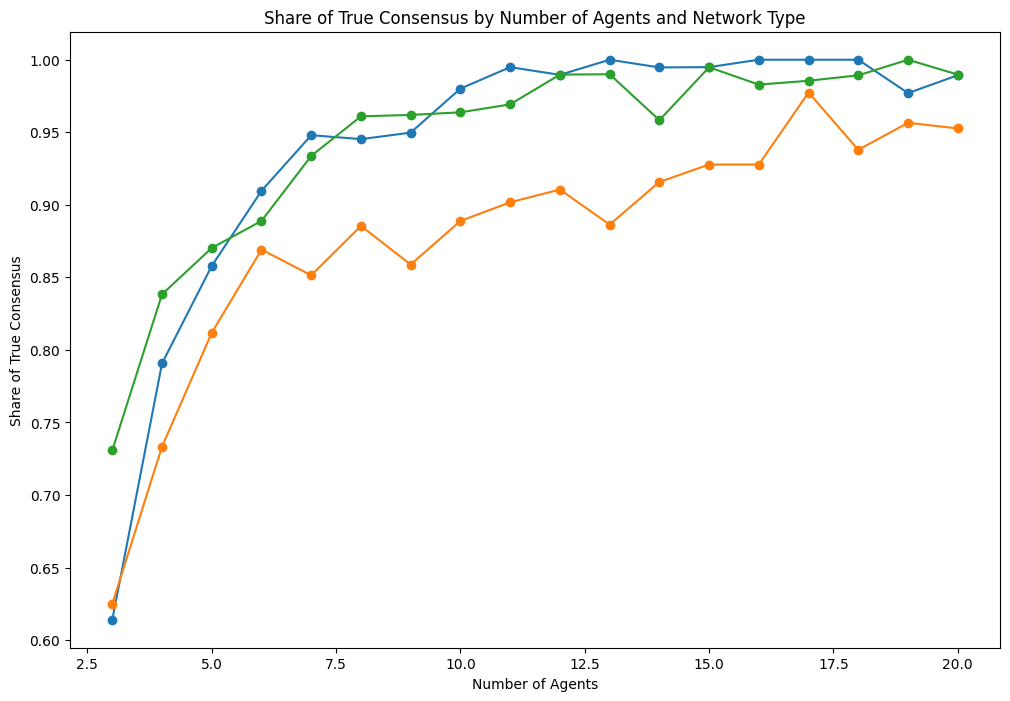

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'df' is your DataFrame with the data
results_df['true_consensus'] = results_df['true_consensus'].astype(int)  # Convert True/False to 1/0

# Define bins for 'n_agents'
# bins = np.linspace(results_df['n_agents'].min(), results_df['n_agents'].max(), 9)  # Adjust number of bins as needed
# results_df['binned'] = pd.cut(results_df['n_agents'], bins, include_lowest=True)
# print(results_df['binned'])
# Calculate the share of true consensus within each bin, for each network type
grouped = results_df.groupby(['network_type', 'n_agents'])['true_consensus'].mean().reset_index()

# Preparing for the line plot
#grouped['mid_bin'] = grouped['binned'].apply(lambda x: x.mid).astype(float)  # Getting the midpoint of bins for plotting

# Plotting
plt.figure(figsize=(12, 8))

for network_type in results_df['network_type'].unique():
    subset = grouped[grouped['network_type'] == network_type]
    plt.plot(subset['n_agents'], subset['true_consensus'], marker='o', label=network_type)

plt.xlabel('Number of Agents')
plt.ylabel('Share of True Consensus')
plt.title('Share of True Consensus by Number of Agents and Network Type')
opinionated.add_legend(title='Network Type')

plt.grid(True)
plt.show()


In [9]:
import pandas as pd
from pygam import LogisticGAM, s
from sklearn.model_selection import train_test_split

# Splitting the DataFrame by network type
network_types = results_df['network_type'].unique()

my_gams = {}

for network_type in network_types:
    # Subset the DataFrame by network type
    subset = results_df[results_df['network_type'] == network_type]
    
    # Preparing the data
    X = subset[['n_agents']]
    y = subset['true_consensus'].astype(int)  # Convert boolean to integer
    
    # Splitting the data into training and testing sets for model validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fitting the Logistic GAM model
    gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
    
    # Storing the model
    my_gams[network_type] = gam
    
    # Optionally, you can print out model accuracy or other statistics here
    print(f"Model for {network_type}:")
    print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
    print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
    print("-" * 30)


ModuleNotFoundError: No module named 'pygam'

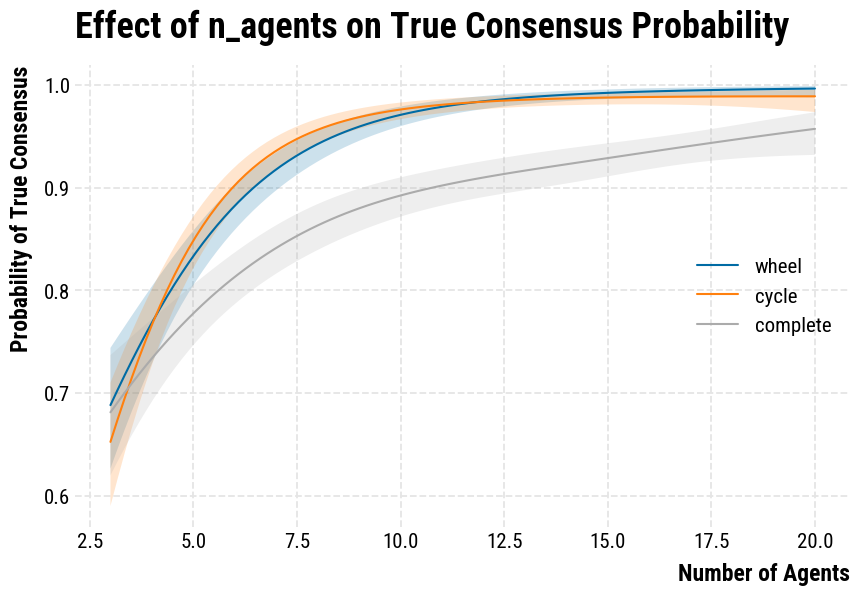

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the figure
plt.figure(figsize=(10, 6))


cmap= cmaps.colorblind_10

X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)


colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

for i, (network_type, gam) in enumerate(my_gams.items()):
    conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
    plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


for i, (network_type, gam) in enumerate(my_gams.items()):
    # Generating a range of values for n_agents to predict and plot
    
    
    # Predicting with the model
    #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
    y_pred = gam.predict_proba(X_range.reshape(-1, 1))

    
    # Plotting predicted probabilities
    plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
    
    # Plotting observed data

    # observed_data = results_df[results_df['network_type'] == network_type]
    # plt.scatter(observed_data['n_agents'] + np.random.rand(len(observed_data)), observed_data['true_consensus'], 
    #             alpha=0.01, c='grey',marker=2)


# Adding title, labels, and legend
plt.title('Effect of n_agents on True Consensus Probability')
plt.xlabel('Number of Agents')
plt.ylabel('Probability of True Consensus')
plt.legend()
plt.show()


9

# Tunable networks

Calculating best minimal value for power law fit
20.089778386169147
4.0


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


<Axes: >

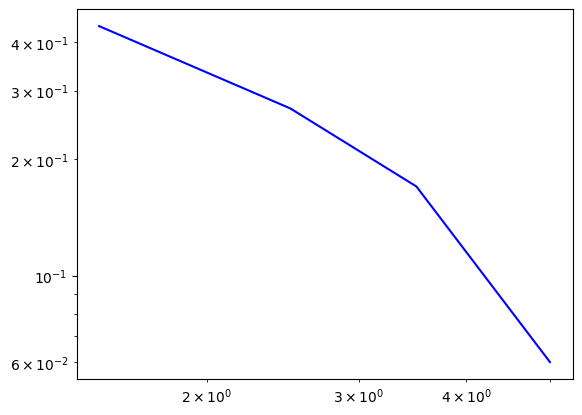

In [64]:
import powerlaw


G = create_hybrid_network(100, degree=1, p_preferential_attachment=.1)

degree_list = [degree for node, degree in G.degree()]

fit = powerlaw.Fit(degree_list)
print(results.power_law.alpha)
print(results.power_law.xmin)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=figCCDF)

R, p = results.distribution_compare('power_law', 'lognormal')

powerlaw.plot_pdf(degree_list, color='b')

In [66]:
import random
import networkx as nx



def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 15)
        degree = random.randint(1, n_agents-1)
        p_preferential_attachment = random.uniform(0, 1)
        network = create_hybrid_network(n_agents, degree=degree, p_preferential_attachment=p_preferential_attachment)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)        
        powerlaw_alpha = powerlaw.Fit([degree for node, degree in network.degree()]) # that odesnt work... /
        
        
        
        
        
        params = {
            "n_agents": n_agents,
            "degree": degree,
            "p_preferential_attachment": p_preferential_attachment,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(10000)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Less than 2 unique data values left after xmin and xmax options! Canno

In [ ]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = batch_run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 10000/10000 [01:15<00:00, 132.10it/s]

      n_agents  degree  p_preferential_attachment  uncertainty  n_experiments  \
0            4       2                   0.492210        0.001           1000   
1           12       7                   0.640592        0.001           1000   
2           13       3                   0.805594        0.001           1000   
3            6       5                   0.253219        0.001           1000   
4           11       5                   0.685990        0.001           1000   
...        ...     ...                        ...          ...            ...   
9995         6       5                   0.865813        0.001           1000   
9996        12       7                   0.784926        0.001           1000   
9997         6       2                   0.177675        0.001           1000   
9998         4       2                   0.691931        0.001           1000   
9999         9       1                   0.986273        0.001           1000   

      true_consensus  true_

In [ ]:
 
    # Preparing the data
X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())


Model for complete:
Accuracy on training data: 0.7221428571428572
Accuracy on test data: 0.71
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.9616
Link Function:                        LogitLink Log Likelihood:                                 -3795.0395
Number of Samples:                         7000 AIC:                                             7612.0021
                                                AICc:                                            7612.0464
                                                UBRE:                                               3.0887
                                                Scale:                                                 1.0
                                                Ps

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/3925743412.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


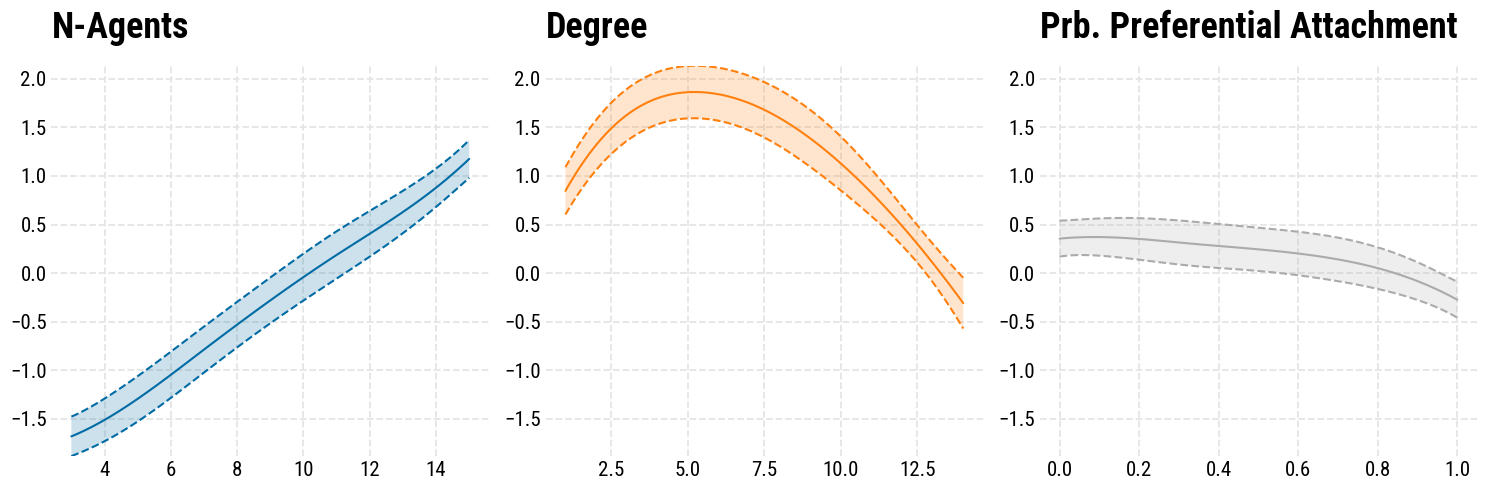

In [ ]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


# Randomized networks

In [94]:
import random
import networkx as nx
from hybrid_networks import randomized_barabasi_albert_graph

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 100)
        n_edges_to_add = random.randint(1, np.max([int(n_agents/10),1])) #rethink
        randomization_probability = random.uniform(0, 1)
        network = randomized_barabasi_albert_graph(n_agents, 
                                                    n_edges_to_add=n_edges_to_add, 
                                                    randomization_probability=randomization_probability)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "n_edges_to_add": n_edges_to_add,
            "randomization_probability": randomization_probability,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)




In [95]:
parameter_dictionaries

[{'n_agents': 6,
  'n_edges_to_add': 1,
  'randomization_probability': 0.3066215272629732,
  'network': <networkx.classes.graph.Graph at 0x2f604c890>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 4,
  'n_edges_to_add': 1,
  'randomization_probability': 0.21376908591860166,
  'network': <networkx.classes.graph.Graph at 0x2f604c390>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 64,
  'n_edges_to_add': 6,
  'randomization_probability': 0.5756424007939364,
  'network': <networkx.classes.graph.Graph at 0x2b9d8fb90>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 67,
  'n_edges_to_add': 6,
  'randomization_probability': 0.8849150780526577,
  'network': <networkx.classes.graph.Graph at 0x2b9a67fd0>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 44,
  'n_edges_to_add': 3,
  'randomization_probability': 0.46759915539183294,
  'network': <networkx.classes.graph.Graph at 0x2b9d85b10>,
  'uncertainty': 0.001,
  'n_experiments

{'n_agents': 6, 'n_edges_to_add': 1, 'randomization_probability': 0.3066215272629732, 'network': <networkx.classes.graph.Graph object at 0x2f604c890>, 'uncertainty': 0.001, 'n_experiments': 1000}


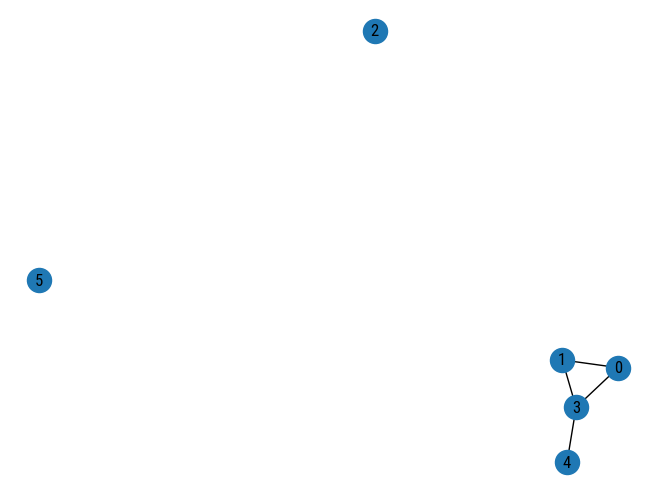

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the network from the parameter dictionary
params = parameter_dictionaries[0]
print(params)
network = params['network']

# Create a graph from the network
graph = nx.Graph(network)

# Plot the graph
nx.draw(graph, with_labels=True)
plt.show()


In [97]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
display(results_df)


Running simulations: 100%|██████████| 10000/10000 [09:41<00:00, 17.18it/s]


,n_agents,n_edges_to_add,randomization_probability,uncertainty,n_experiments,true_consensus,true_consensus_alternative_stop
0,35,1,0.465802,0.001,1000,0.828571,0.828571
1,7,1,0.126811,0.001,1000,1.000000,1.000000
2,39,3,0.870653,0.001,1000,1.000000,1.000000
3,8,1,0.697600,0.001,1000,0.875000,0.875000
4,64,2,0.709067,0.001,1000,0.968750,0.968750
...,...,...,...,...,...,...,...
9995,44,4,0.453453,0.001,1000,1.000000,1.000000
9996,16,1,0.161439,0.001,1000,1.000000,1.000000
9997,67,2,0.138573,0.001,1000,1.000000,1.000000
9998,36,3,0.367534,0.001,1000,1.000000,1.000000


In [98]:

 
    # Preparing the data
X = results_df[['n_agents', 'n_edges_to_add', 'randomization_probability']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

Model for complete:
Accuracy on training data: 0.8481428571428572
Accuracy on test data: 0.8496666666666667
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      9.5573
Link Function:                        LogitLink Log Likelihood:                                 -2388.4934
Number of Samples:                         7000 AIC:                                             4796.1014
                                                AICc:                                            4796.1363
                                                UBRE:                                               2.6862
                                                Scale:                                                 1.0
                                    

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/2392922359.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


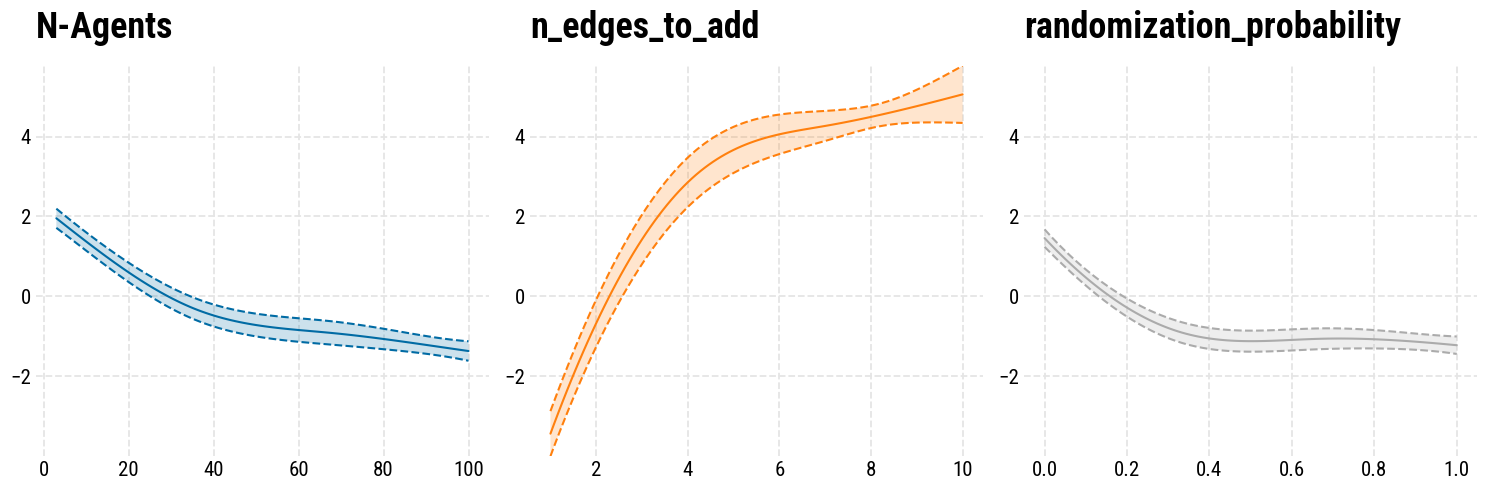

In [99]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'n_edges_to_add', 'randomization_probability']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


# Fixed networks

In [36]:
import numpy as np
from agents_clean import Agent
from model_clean import Model
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network
from tqdm import tqdm
import networkx as nx
import pandas as pd
import random
import numbers
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps  

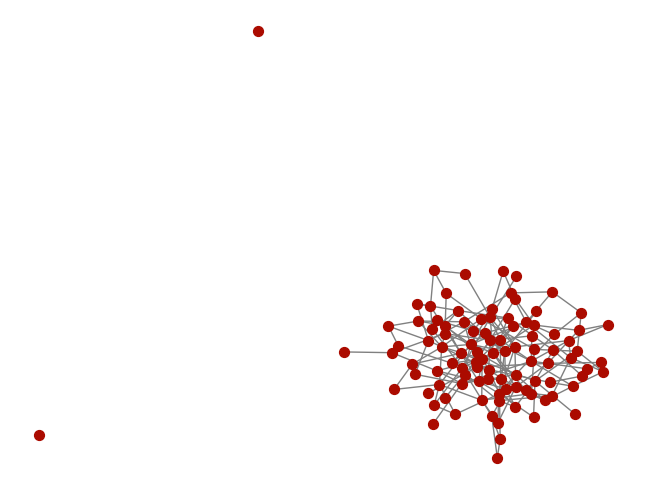

In [484]:
#G = nx.barabasi_albert_graph(100, 2)
G=nx.watts_strogatz_graph(100, 4,p=0., seed=None) 
G = randomize_network_v2(G, p_rewiring=1)

pos_sf = nx.spring_layout(G)


nx.draw(G, pos_sf, node_color='#ab0b00', edge_color='gray', node_size=50)

2
10000
4
10000
6
10000
2
9913
4
10000
6
10000
2
9775
4
10000
6
10000
2
9608
4
10000
6
10000
2
9491
4
10000
6
10000
2
9400
4
10000
6
10000
2
9341
4
10000
6
10000
2
9318
4
10000
6
10000
2
9279
4
10000
6
10000
2
9293
4
10000
6
10000
2
9348
4
10000
6
10000
2
9322
4
10000
6
10000
2
9391
4
10000
6
10000
2
9397
4
10000
6
10000
2
9436
4
10000
6
10000
2
9386
4
10000
6
10000
2
9444
4
10000
6
10000
2
9436
4
10000
6
10000
2
9465
4
10000
6
10000
2
9430
4
10000
6
10000


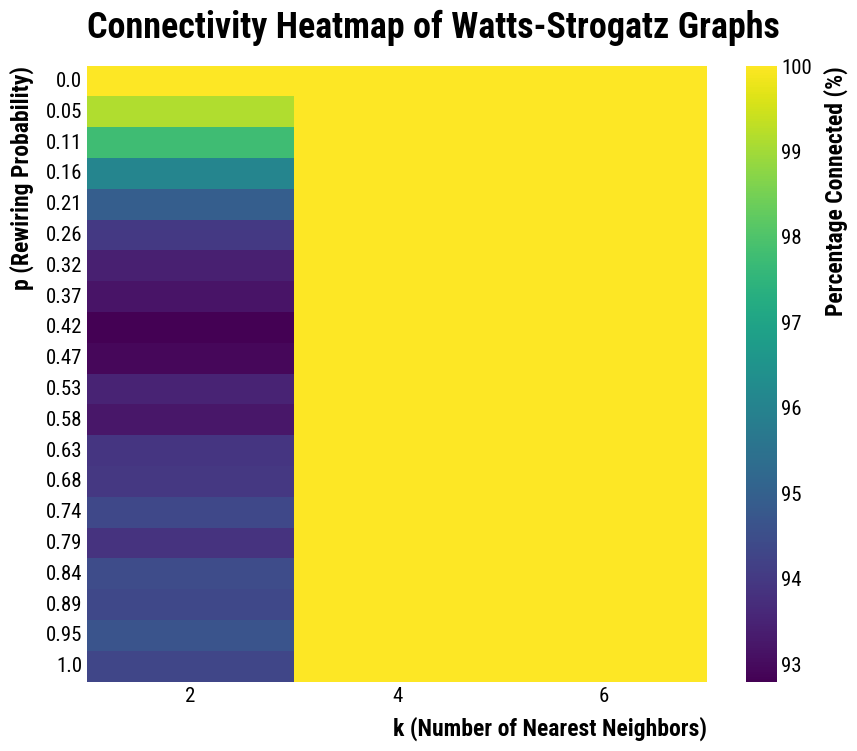

In [425]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

# Parameters
n = 10              # Number of nodes
num_graphs = 10000     # Number of graphs to generate for each (p, k) pair
p_values = np.linspace(0, 1, 20)   # Range of p values
k_values = range(2, 8, 2)         # Range of k values
seed = None                        # Seed for reproducibility

# Initialize a matrix to store the percentage of connected graphs
connectivity = np.zeros((len(p_values), len(k_values)))

# Generate graphs and compute connectivity
for i, p in enumerate(p_values):
    for j, k in enumerate(k_values):
        print(k)
        connected_count = 0
        for _ in range(num_graphs):
            G = nx.watts_strogatz_graph(n, k, p)
            if nx.is_connected(G):
                
                connected_count += 1
        print(connected_count)
        connectivity[i, j] = connected_count / num_graphs * 100  # Store the percentage of connected graphs

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(connectivity, xticklabels=k_values, yticklabels=np.round(p_values, 2),
            cmap='viridis', annot=False, fmt=".0f", cbar_kws={'label': 'Percentage Connected (%)'})
plt.xlabel('k (Number of Nearest Neighbors)')
plt.ylabel('p (Rewiring Probability)')
plt.title('Connectivity Heatmap of Watts-Strogatz Graphs')
plt.show()

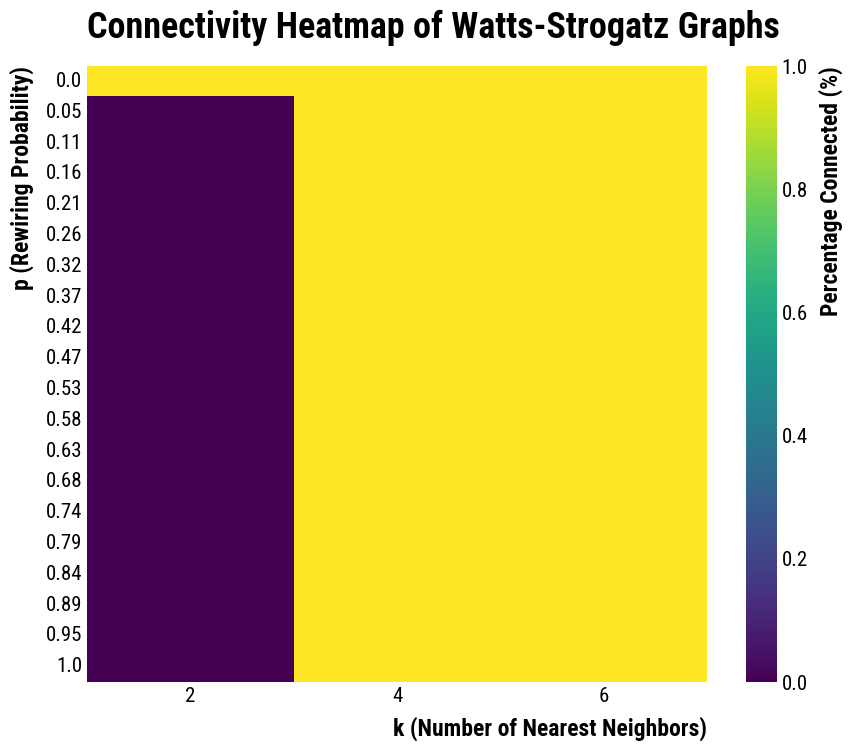

In [426]:
plt.figure(figsize=(10, 8))
sns.heatmap(connectivity ==100, xticklabels=k_values, yticklabels=np.round(p_values, 2),
            cmap='viridis', annot=False, fmt=".0f", cbar_kws={'label': 'Percentage Connected (%)'})
plt.xlabel('k (Number of Nearest Neighbors)')
plt.ylabel('p (Rewiring Probability)')
plt.title('Connectivity Heatmap of Watts-Strogatz Graphs')
plt.show()

In [435]:
np.log(3)

1.0986122886681098

In [244]:
import random

In [488]:
def generate_parameters(n,network=None):
    params_list = []
    #print('Generating parameters...')
    for _ in tqdm(range(n),desc="Generating parameters"):
        n_agents =  len(network)

        p_rewiring = random.uniform(0,0.01)# 1)


        network = randomize_network_v2(G, p_rewiring=p_rewiring)


        degrees = dict(network.degree())
        mean_degree = sum(degrees.values()) / len(degrees)
        
        avg_shortest_path = nx.average_shortest_path_length(network)
        average_clustering = nx.average_clustering(network)
        n_isolates = len(list(nx.isolates(network)))
        
        uncertainty = random.uniform(0.0005,0.004)
        n_experiments = random.randint(10, 100)
        params = {
            "n_agents": n_agents,
            "p_rewiring": p_rewiring,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments,
            'mean_degree':mean_degree,
            'avg_shortest_path':avg_shortest_path,
            'avg_clustering':average_clustering,
            'n_isolates':n_isolates,
        }
        params_list.append(params)
    return params_list

In [489]:
generate_parameters(100,network=G)

Generating parameters:   0%|          | 0/100 [00:00<?, ?it/s]


NetworkXError: Graph is not connected.

In [478]:
import numpy as np
import numbers

def run_simulation_with_params(param_dict, number_of_steps=1000, show_bar=False):
    # Extract the network directly since it's already a NetworkX graph object
    my_network = param_dict['network']
    # Other parameters are directly extracted from the dictionary
    my_model = Model(my_network, n_experiments=param_dict['n_experiments'], uncertainty=param_dict['uncertainty'], agent_type="bayes")
    # Run the simulation with predefined steps and show_bar option
    
    my_model.run_simulation(number_of_steps=number_of_steps, show_bar=show_bar)
    

    result_dict = {
        key: value 
        for key, value in param_dict.items() 
        if isinstance(value, (numbers.Number, str, tuple, list))}   
    result_dict['true_consensus'] = my_model.conclusion
    result_dict['true_consensus_alternative_stop'] = my_model.conclusion_alternative_stop
    
    return result_dict


parameter_dictionaries = generate_parameters(1000,G)  # Generate one for demonstration
result = run_simulation_with_params(parameter_dictionaries[1], number_of_steps=10000, show_bar=False)
print(result)



Generating parameters: 100%|██████████| 1000/1000 [00:03<00:00, 328.83it/s]


{'n_agents': 100, 'p_rewiring': 0.003552167125609358, 'uncertainty': 0.0018691864434518734, 'n_experiments': 72, 'mean_degree': 4.0, 'avg_shortest_path': 12.878787878787879, 'avg_clustering': 0.5, 'n_isolates': 0, 'true_consensus': 1.0, 'true_consensus_alternative_stop': 1.0}


In [479]:

import pandas as pd
from tqdm import tqdm

# Ensure your run_simulation_with_params function and others are defined

def run_simulations(param_list, number_of_steps=1000, show_bar=False):
    def run_simulation(param_dict):
        return run_simulation_with_params(param_dict, number_of_steps=number_of_steps, show_bar=show_bar)
    
    results = []
    # Iterate over each parameter dictionary in the list
    for params in tqdm(param_list, desc="Running simulations"):
        result = run_simulation(params)
        results.append(result)
    
    # Convert the list of results into a Pandas DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
parameter_dictionaries = generate_parameters(1000,G)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=2000, show_bar=False)
print(results_df)

Running simulations: 100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]

     n_agents  p_rewiring  uncertainty  n_experiments  mean_degree  \
0         100    0.002436     0.000938             87          4.0   
1         100    0.001464     0.003405             52          4.0   
2         100    0.002815     0.002244             47          4.0   
3         100    0.006926     0.003295             48          4.0   
4         100    0.001113     0.003673             11          4.0   
..        ...         ...          ...            ...          ...   
995       100    0.007742     0.001940             48          4.0   
996       100    0.007652     0.000699             20          4.0   
997       100    0.003624     0.001744             87          4.0   
998       100    0.007795     0.000845             41          4.0   
999       100    0.000690     0.003713             74          4.0   

     avg_shortest_path  avg_clustering  n_isolates  true_consensus  \
0            12.878788             0.5           0            0.78   
1            12.878

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
    
def plot_scatter_matrix(X, y, max_cols=3, filename=None):
    """
    Plots scatterplots of all columns in DataFrame X against the target vector y,
    with an adjustable number of columns per row and centering if the last row is incomplete.
    
    Parameters:
    X : DataFrame
        Input data with multiple columns.
    y : array-like
        Target variable data.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    columns = X.columns
    target_name = y.columns[0]
    plot_count = len(columns)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    # Create subplots
    for idx, col in enumerate(columns):
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        ax.scatter(X.iloc[:, idx], y, c='#ab0b00', alpha=.2)
        ax.set_xlabel(columns[idx])
        if col == 0:
            ax.set_ylabel(target_name)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()

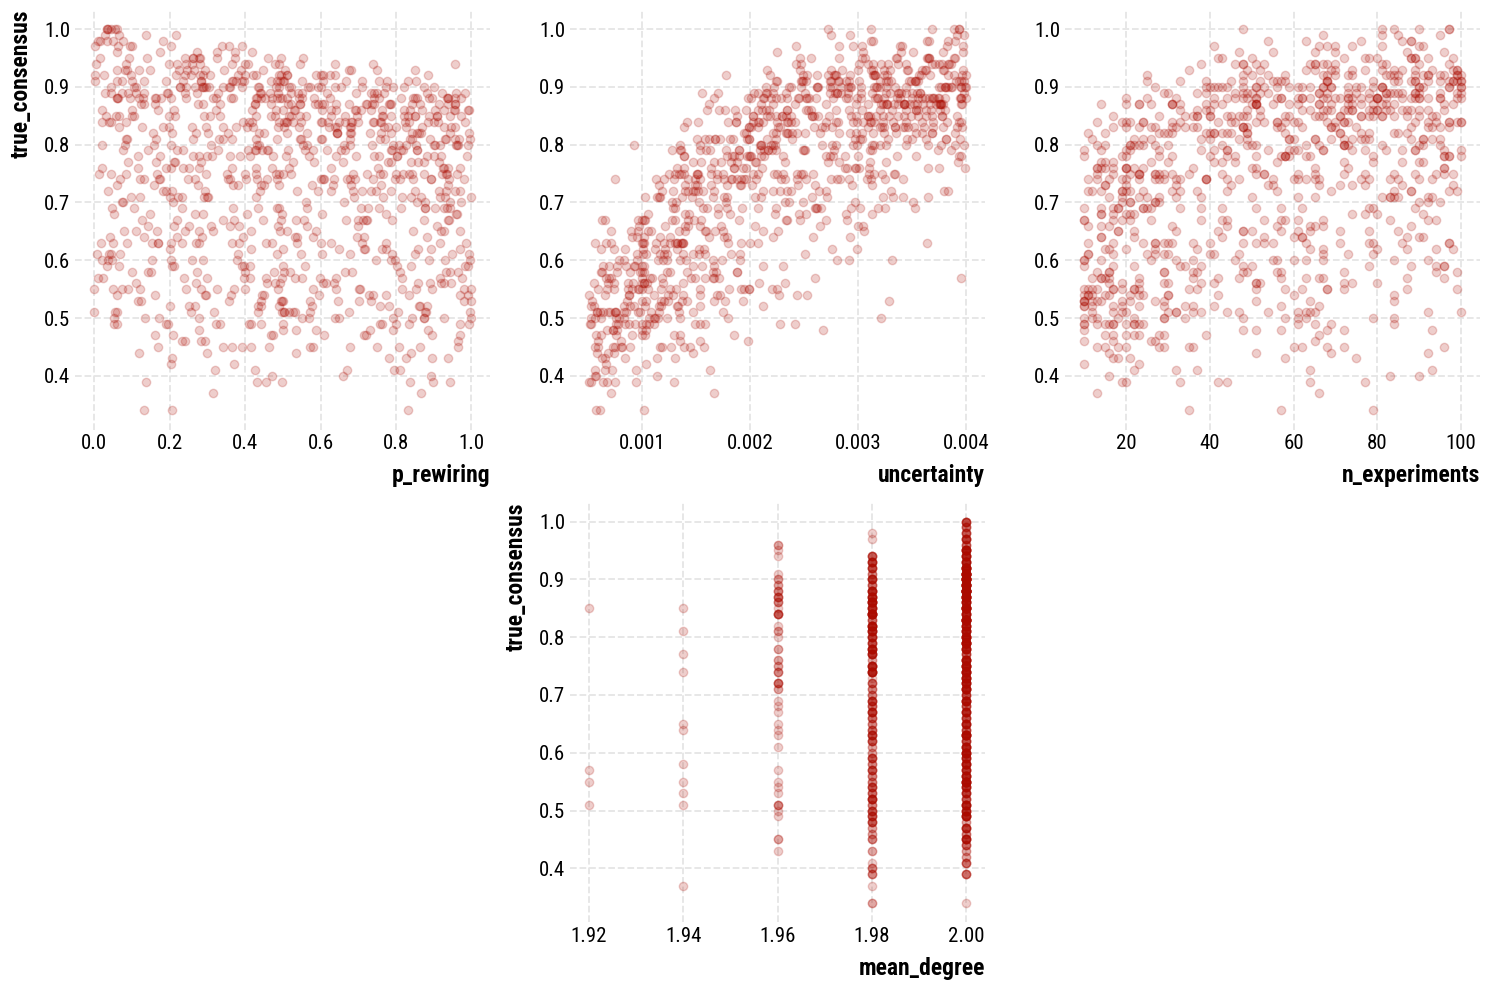

In [ ]:

X = results_df[['p_rewiring',	'uncertainty',	'n_experiments','mean_degree']]
y = pd.DataFrame(results_df['true_consensus'])

plot_scatter_matrix(X, y, max_cols=3, filename=None)


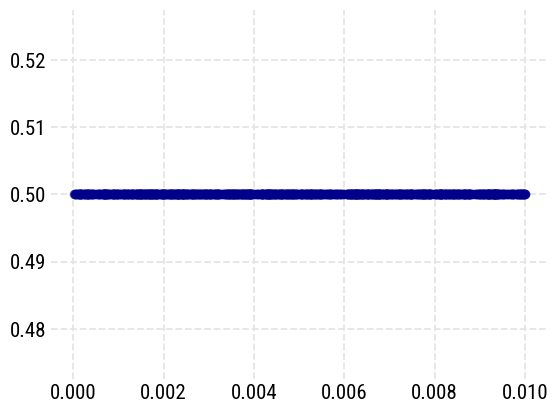

In [487]:

# X = results_df[['mean_degree',	'avg_shortest_path',	'avg_clustering'	]]
# y = pd.DataFrame(results_df['p_rewiring'])

# plot_scatter_matrix(X, y, max_cols=3, filename=None)

plt.scatter(results_df['p_rewiring'], results_df['avg_clustering'],alpha=.5,c='darkblue')
